<font size=7 color ="#5499C7" >Audio MNIST</font>
- <font size=5>__Done By__ : Kasra Noorbakhsh</font>
- <font size=5>__UID__  : 810100230</font>
- <font size=5>__Goal__  : Digit and Speaker Recognition</font>
- <font size=5>__Dataset Path__  : ./data</font>

### <p align="justify"><font size="6" color="#d62b5b">Step 1: Initialization and Overview</font></p>
<p align="justify">

<p align="justify"><font size="6" color="#A9CCE3"><b>Section 0: Setup & imports</b></font><br></p>

In [8]:
import os
import json
import tqdm
import torch
import random
import librosa
import numpy as np
import pandas as pd
from glob import glob
import torch.nn as nn
import librosa.display
import soundfile as sf
import torch.optim as optim
import IPython.display as ipd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# parameters
TARGET_SR = 16000
TARGET_LEN = TARGET_SR  # 1 second = 16000 samples
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 1024
num_classes = 10
batch_size = 64
num_epochs = 15

# Paths
DATA_ROOT = "data"

# Check GPU (if using torch later)
try:
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Torch device:", device)
except Exception:
    device = None
    print("Torch not available in this environment")

Torch device: cpu


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 1: Gather file list & quick metadata</b></font></p>

In [9]:
rows = []
for speaker_folder in sorted(glob(os.path.join(DATA_ROOT, "*"))):
    speaker_id = os.path.basename(speaker_folder)
    if not speaker_id.isdigit(): 
        continue
    for wav_path in glob(os.path.join(speaker_folder, "*.wav")):
        fname = os.path.basename(wav_path)
        # Expect format: digit_speaker_iter.wav e.g. 0_04_20.wav
        parts = fname.replace(".wav","").split("_")
        if len(parts) < 3:
            # log weird filenames
            rows.append({"path": wav_path, "speaker": speaker_id, "digit": None, "iter": None, "flag_bad_name": True})
            continue
        digit = int(parts[0])
        speaker_code = parts[1]
        iteration = parts[2]
        rows.append({"path": wav_path, "speaker": speaker_id, "digit": digit, "iter": iteration, "flag_bad_name": False})

df = pd.DataFrame(rows)
print("Total files:", len(df))
print(df.head())

Total files: 30000
                  path speaker  digit iter  flag_bad_name
0   data\01\0_01_0.wav      01      0    0          False
1   data\01\0_01_1.wav      01      0    1          False
2  data\01\0_01_10.wav      01      0   10          False
3  data\01\0_01_11.wav      01      0   11          False
4  data\01\0_01_12.wav      01      0   12          False


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 2: Durations and sample rate checks</b></font></p>

Sample rate(s) found (sample of files): {48000}
Duration stats (sample): mean=0.645 s, median=0.636 s, max=0.995 s


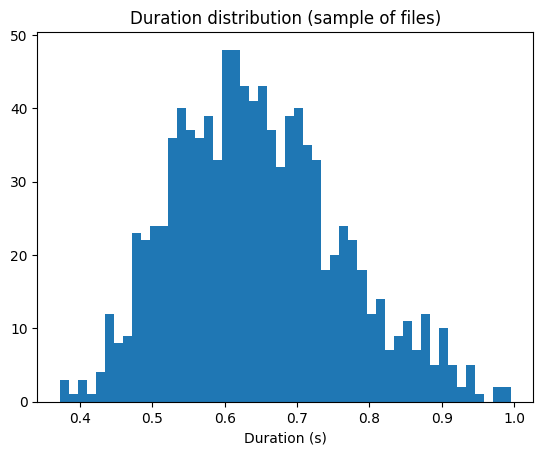

In [10]:
# Compute durations and sample rates for a sample files
# Warning: reading all files can take time. We'll sample 1000 files first, then optionally run full check.
sample_paths = df['path'].sample(min(1000, len(df)), random_state=RANDOM_SEED).tolist()

durations = []
sr_set = set()
for p in sample_paths:
    try:
        info = sf.info(p)
        sr_set.add(info.samplerate)
        durations.append(info.frames / info.samplerate)
    except Exception as e:
        print("Failed reading", p, e)

print("Sample rate(s) found (sample of files):", sr_set)
print("Duration stats (sample): mean=%.3f s, median=%.3f s, max=%.3f s" % (np.mean(durations), np.median(durations), np.max(durations)))

plt.hist(durations, bins=50)
plt.xlabel("Duration (s)")
plt.title("Duration distribution (sample of files)")
plt.show()

### <p align="justify"><font size="6" color="#d62b5b">Step 2: Data cleaning and preprocessing</font></p>
<p align="justify">

- Convert all audio to 16 kHz mono

- Normalize and trim/pad to 1 s

- Extract log-Mel spectrograms (128 Mel bins)

- Cache features for training

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 3: Preprocessing Functions</b></font></p>

In [11]:
def load_and_preprocess(path, target_sr=TARGET_SR, target_len=TARGET_LEN):
    y, sr = librosa.load(path, sr=None, mono=True)
    # Resample
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    # Normalize
    y = y / np.max(np.abs(y) + 1e-9)
    # Trim/pad to 1 s
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    elif len(y) > target_len:
        y = y[:target_len]
    return y, sr

def to_logmel(y, sr, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=N_FFT):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    logmel = librosa.power_to_db(mel, ref=np.max)
    return logmel.astype(np.float32)

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 4: Quick Visual Check</b></font></p>

Sample path: data\42\9_42_10.wav
Wave shape: (16000,), log-Mel shape: (128, 32)


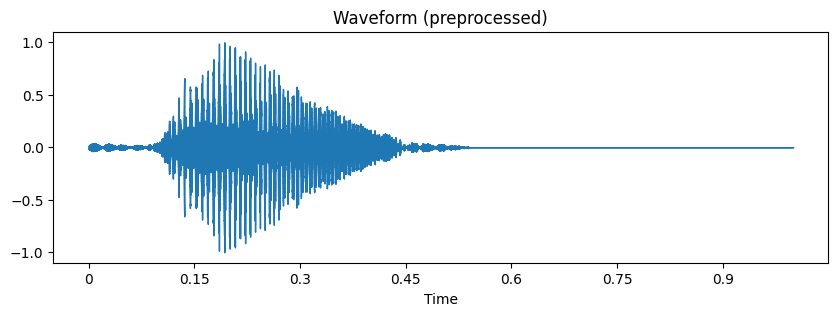

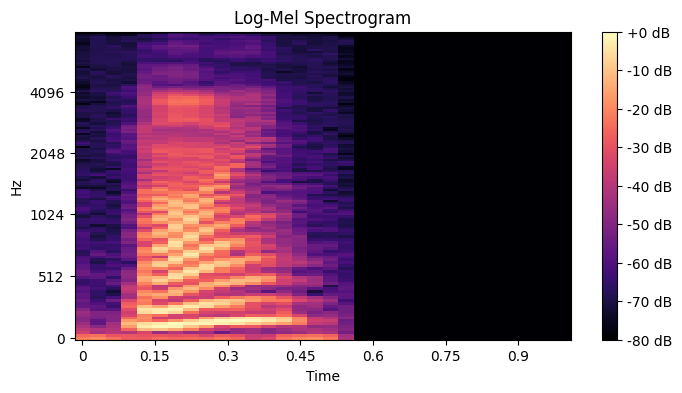

In [12]:
# Test on one random file
sample_path = random.choice(df['path'].tolist())
y, sr = load_and_preprocess(sample_path)
logmel = to_logmel(y, sr)

print(f"Sample path: {sample_path}")
print(f"Wave shape: {y.shape}, log-Mel shape: {logmel.shape}")

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform (preprocessed)")
plt.show()

plt.figure(figsize=(8, 4))
librosa.display.specshow(logmel, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.show()

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 5: Feature Extraction Loop (Preview)</b></font></p>

In [13]:
subset = df.sample(100, random_state=RANDOM_SEED)
features = []
for p in tqdm.tqdm(subset['path'], desc="Extracting sample features"):
    y, sr = load_and_preprocess(p)
    logmel = to_logmel(y, sr)
    features.append(logmel)

features = np.stack(features)
print("Feature batch shape:", features.shape)

Extracting sample features: 100%|██████████| 100/100 [00:01<00:00, 99.68it/s]

Feature batch shape: (100, 128, 32)


### <p align="justify"><font size="6" color="#d62b5b">Step 3: Feature Extraction and Dataset Preparation</font></p>
<p align="justify">

- Extract and cache all log-Mel features

- Create metadata.csv

- Split dataset by speaker

- Check balance and feature shapes

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 6: Cache extraction(Run Once)</b></font></p>

In [14]:
CACHE_DIR = "cached_features"
os.makedirs(CACHE_DIR, exist_ok=True)

metadata = []

for i, row in tqdm.tqdm(df.iterrows(), total=len(df), desc="Extracting & caching all features"):
    y, sr = load_and_preprocess(row.path)
    logmel = to_logmel(y, sr)
    # Save compressed numpy file
    feature_path = os.path.join(CACHE_DIR, f"{os.path.basename(row.path).replace('.wav','.npy')}")
    np.save(feature_path, logmel)
    metadata.append({
        "feature_path": feature_path,
        "digit": row.digit,
        "speaker": row.speaker
    })

meta_df = pd.DataFrame(metadata)
meta_df.to_csv(os.path.join(CACHE_DIR, "metadata.csv"), index=False)
print("Cached features:", len(meta_df))

Extracting & caching all features: 100%|██████████| 30000/30000 [12:02<00:00, 41.54it/s]


Cached features: 30000


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 7: Split by speaker (speaker-disjoint)</b></font></p>

Speakers: train=42, val=9, test=9
Train: 21000 samples, 42 speakers
Val: 4500 samples, 9 speakers
Test: 4500 samples, 9 speakers


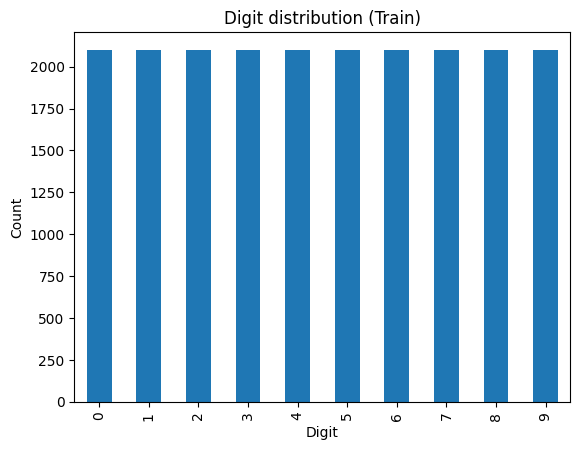

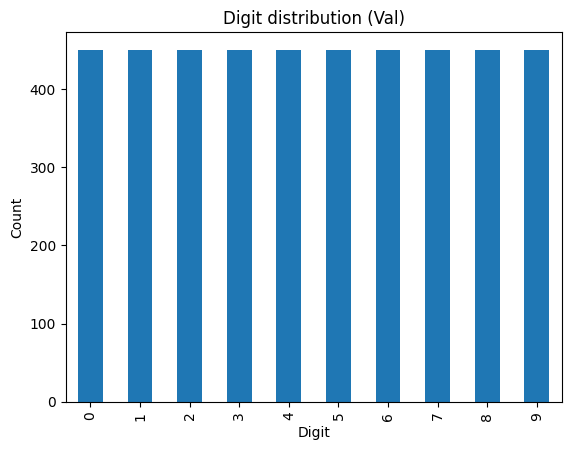

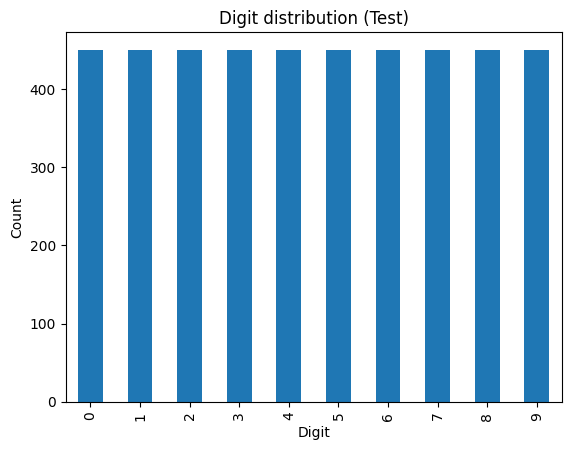

In [15]:
speakers = sorted(meta_df['speaker'].unique())
train_spk, temp_spk = train_test_split(speakers, test_size=0.3, random_state=RANDOM_SEED)
val_spk, test_spk = train_test_split(temp_spk, test_size=0.5, random_state=RANDOM_SEED)

print(f"Speakers: train={len(train_spk)}, val={len(val_spk)}, test={len(test_spk)}")

def split_by_speakers(df, spk_list):
    return df[df['speaker'].isin(spk_list)].reset_index(drop=True)

train_df = split_by_speakers(meta_df, train_spk)
val_df   = split_by_speakers(meta_df, val_spk)
test_df  = split_by_speakers(meta_df, test_spk)

for name, d in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    print(f"{name}: {len(d)} samples, {d['speaker'].nunique()} speakers")


for name, d in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    plt.figure()
    d['digit'].value_counts().sort_index().plot.bar()
    plt.title(f"Digit distribution ({name})")
    plt.xlabel("Digit")
    plt.ylabel("Count")
    plt.show()

### <p align="justify"><font size="6" color="#d62b5b">Step 4: Model Selection and Training</font></p>
<p align="justify">

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 8: Digit Recognition (main task)</b></font></p>

- 10-class classification problem (digits 0–9) using 2D Mel spectrograms.

    | Model                                         | Description                             | Pros                                       |
    | --------------------------------------------- | --------------------------------------- | ------------------------------------------ |
    | **CNN-Small**                                 | 2–3 convolutional blocks + dense layers | Fast to train, simple baseline             |
    | **CNN-LSTM Hybrid**                           | CNN feature extractor → BiLSTM → Dense  | Learns temporal dependencies better        |
    | **CRNN** (Convolutional Recurrent Neural Net) | Common in speech recognition            | Great trade-off between accuracy and speed |

In [19]:
class CNN_Small(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Small, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)

        # We'll define fc1 dynamically later
        self.fc1 = None
        self.fc2 = None
        self.num_classes = num_classes

    def _initialize_fc(self, x):
        """Initialize fully connected layers dynamically based on input shape."""
        n_features = x.view(x.size(0), -1).shape[1]
        self.fc1 = nn.Linear(n_features, 256)
        self.fc2 = nn.Linear(256, self.num_classes)
        self.to(x.device)  # move to same device

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        if self.fc1 is None:
            self._initialize_fc(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Small(num_classes).to(device)
print(model)

CNN_Small(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
)


⚙️ Training Setup

In [17]:
# Helper: load cached .npy features
def load_features(df):
    feats = []
    for path in df['feature_path']:
        feat = np.load(path)  # each is (128, 32)
        feats.append(feat)
    return np.array(feats)

X_train = load_features(train_df)
Y_train = train_df['digit'].to_numpy()
X_val   = load_features(val_df)
Y_val   = val_df['digit'].to_numpy()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
Y_val_tensor   = torch.tensor(Y_val, dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

🏋️‍♂️ Training Loop

In [20]:
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("✅ Training complete.")

Epoch [1/15] - Train Loss: 2.3856, Val Loss: 2.3472, Val Acc: 10.36%
Epoch [2/15] - Train Loss: 2.3874, Val Loss: 2.3475, Val Acc: 10.36%
Epoch [3/15] - Train Loss: 2.3864, Val Loss: 2.3476, Val Acc: 10.47%
Epoch [4/15] - Train Loss: 2.3859, Val Loss: 2.3477, Val Acc: 10.38%
Epoch [5/15] - Train Loss: 2.3892, Val Loss: 2.3475, Val Acc: 10.36%
Epoch [6/15] - Train Loss: 2.3829, Val Loss: 2.3476, Val Acc: 10.51%
Epoch [7/15] - Train Loss: 2.3847, Val Loss: 2.3479, Val Acc: 10.44%
Epoch [8/15] - Train Loss: 2.3847, Val Loss: 2.3475, Val Acc: 10.47%
Epoch [9/15] - Train Loss: 2.3854, Val Loss: 2.3471, Val Acc: 10.33%
Epoch [10/15] - Train Loss: 2.3862, Val Loss: 2.3476, Val Acc: 10.38%
Epoch [11/15] - Train Loss: 2.3879, Val Loss: 2.3474, Val Acc: 10.36%
Epoch [12/15] - Train Loss: 2.3870, Val Loss: 2.3478, Val Acc: 10.51%
Epoch [13/15] - Train Loss: 2.3859, Val Loss: 2.3477, Val Acc: 10.51%
Epoch [14/15] - Train Loss: 2.3841, Val Loss: 2.3471, Val Acc: 10.40%
Epoch [15/15] - Train Loss: 2